Part 3 - CartPole

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
from gym.wrappers import AtariPreprocessing, FrameStack



# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

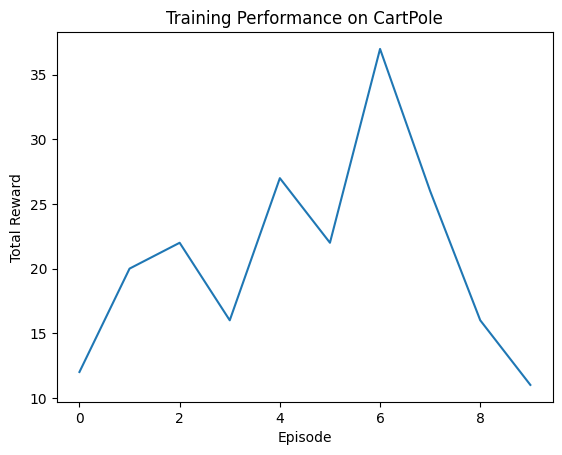

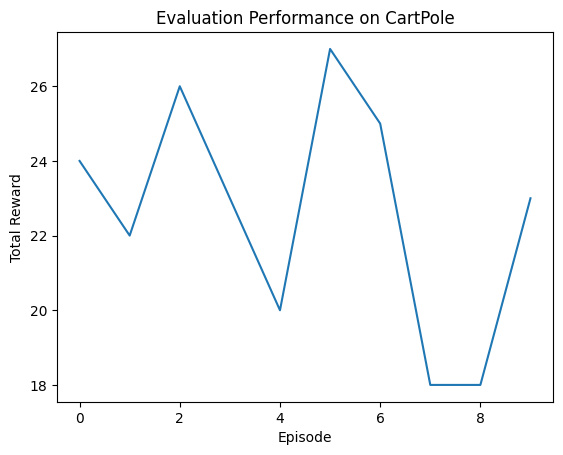

In [7]:
class SharedActorCritic(nn.Module):
  def __init__(self, state_dim, action_dim, hidden_dim):
    super(SharedActorCritic, self).__init__()

    # base
    self.shared_base = nn.Sequential(
        nn.Linear(state_dim, hidden_dim),
        nn.ReLU()
    )

    # actor head
    self.actor_head = nn.Sequential(
        nn.Linear(hidden_dim, action_dim),
        nn.Softmax(dim=1)
    )

    # critic head
    self.critic_head = nn.Linear(hidden_dim, 1)

  def forward(self, state):
      shared_features = self.shared_base(state)
      action_probs = self.actor_head(shared_features)
      state_value = self.critic_head(shared_features)
      return action_probs, state_value

env = gym.make('CartPole-v1')
state_dim = 4
action_dim = 2
hidden_dim = 64
learning_rate = 0.001
instance = SharedActorCritic(state_dim, action_dim, hidden_dim)
optimizer = optim.Adam(instance.parameters(), learning_rate)
num_episodes = 10
gamma = .99

def reward_function(rewards, next, gamma):
  returns = []
  R = next
  # might need to do rewards[::-1]
  for r in rewards:
    R = r + gamma * R
    returns.insert(0, R)
  return returns

#training loop ----------
reward_history = []
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    log_probs_list = []
    rewards = []
    values = []
    actions = []

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action_probs, state_value = instance(state_tensor)

        # select aciton
        action = torch.multinomial(action_probs, 1).item()

        # store log probability of selected action
        log_prob = torch.log(action_probs.squeeze(0)[action])
        log_probs_list.append(log_prob)

        #take action
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        rewards.append(reward)
        values.append(state_value)
        actions.append(action)
        total_reward += reward
        state = next_state

    next_state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    new_action_probs, next_state_value = instance(next_state_tensor)
    returns = reward_function(rewards, next_state_value.item(), gamma)

    returns = torch.tensor(returns)
    values = torch.cat(values).squeeze(1)
    advantages = returns - values.detach()

    actions = torch.tensor(actions)

    log_probs = torch.stack(log_probs_list)
    actor_loss = -(log_probs * advantages).mean()
    critic_loss = F.mse_loss(values, returns)

    total_loss = actor_loss + critic_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    reward_history.append(total_reward)
    
#----------

# plotting training
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance on CartPole')
plt.show()

#eval loop
eval_rewards = []

for episode in range(10):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probs, state_value = instance(state_tensor)
        action = torch.argmax(action_probs).item()

        # choose action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    eval_rewards.append(total_reward)

#evaluation plot
plt.plot(eval_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation Performance on CartPole')
plt.show()




